# Visualsing Active Selections via PCA

In [1]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.cross_validation import KFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from mclearn.active import ActiveLearner
from mclearn.classifier import grid_search_logistic
from mclearn.heuristics import (random_h, margin_h, entropy_h,
                                qbb_margin_h, qbb_kl_h,
                                pool_entropy_h, pool_variance_h)
from mclearn.preprocessing import balanced_train_test_split
from mclearn.tools import results_exist, load_results
from mclearn.viz import plot_average_learning_curve, plot_scatter_with_classes
%matplotlib inline
sns.set_style('ticks')

In [3]:
vstatlas = pd.read_hdf('../data/vstatlas.h5', 'vstatlas')
fig_dir = '../thesis/figures/'
target_col = 'class'
feature_cols = ['rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']

In [31]:
kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=0.3, train_size=0.7, random_state=19)

In [37]:
pd.Series.plot?

In [40]:
logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=100, random_state=2, class_weight='auto')

In [49]:
from sklearn import metrics

In [51]:
for train_test, sel in zip(kfold, balanced_logistic_sels[0]):
    train, test = train_test
    print(pd.Series(y[train][sel]).value_counts())
    logistic.fit(X[train][sel], y[train][sel])
    y_pred = logistic.predict(X[test])
    print(metrics.confusion_matrix(y[test], y_pred))

Star           175
Galaxy          66
Quasar          33
White Dwarf     26
dtype: int64
[[1531   94  343    0]
 [  22  648    2   19]
 [ 360    3 7316    2]
 [   0    0    1  176]]
Star           147
Galaxy          82
Quasar          46
White Dwarf     25
dtype: int64
[[1510  127  331    0]
 [  10  667    3   11]
 [ 613    3 7057    8]
 [   1    1    0  175]]
Star           180
Galaxy          62
Quasar          45
White Dwarf     13
dtype: int64
[[1494   76  398    0]
 [  23  656    5    7]
 [ 504   10 7162    5]
 [   1    0    2  174]]
Star           148
Galaxy          86
Quasar          49
White Dwarf     17
dtype: int64
[[1607  165  196    0]
 [  12  665    4   10]
 [ 683    2 6992    4]
 [   0    1    1  175]]
Star           155
Galaxy          64
Quasar          51
White Dwarf     30
dtype: int64
[[1508   57  403    0]
 [  10  655    6   20]
 [ 286    6 7371   18]
 [   0    1    0  176]]
Star           142
Galaxy          80
Quasar          51
White Dwarf     27
dtype: int64
[

In [11]:
X = np.array(vstatlas[feature_cols])
y = np.array(vstatlas[target_col])
X_pool, _, y_pool, _ = balanced_train_test_split(X, y, train_size=2360, test_size=0, random_state=11)
kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=0.3, train_size=0.7, random_state=19)
for train_index, test_index in kfold:
    X_train = X_pool[train_index]
    y_train = y_pool[train_index]
    break
    
pca = PCA(n_components=2)
X_p = pca.fit_transform(X)
#X_train_p = pca.transform(X_train)
classes = ['Star', 'Galaxy', 'Quasar', 'White Dwarf']

In [12]:
# These are the "Tableau 20" colors as RGB.
tableau10 = [(214, 39, 40), (31, 119, 180), (44, 160, 44),
             (255, 127, 14), (148, 103, 189), (140, 86, 75),
             (127, 127, 127), (23, 190, 207), (188, 189, 34), (227, 119, 194)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau10)):
    r, g, b = tableau10[i]
    tableau10[i] = (r / 255., g / 255., b / 255.)

In [13]:
pickle_paths = ['../pickle/07_thompson_sampling/vstatlas_unbalanced_logistic_candidates.pickle']

balanced_logistic_sels = load_results(pickle_paths)

In [14]:
fig = plt.figure(figsize=(9, 5))
ax = plot_average_learning_curve(np.arange(50, 301), [[balanced_logistic_lcs[0][0]]], ['Entropy'])

NameError: name 'balanced_logistic_lcs' is not defined

In [44]:
order = balanced_logistic_sels[0][0]

IndexError: list index out of range

In [16]:
X_train[:, [5,6]]

array([[-2.81359434, -2.81449366],
       [ 0.36900815,  0.3601186 ],
       [-2.81359434, -2.81449366],
       ..., 
       [ 0.33392677,  0.36651027],
       [ 0.35876215,  0.35687295],
       [ 0.3337734 ,  0.36174953]])

In [30]:
pd.Series(y[order[50:]]).value_counts()

Star           177
Galaxy          48
Quasar          19
White Dwarf      6
dtype: int64

In [18]:
X_p.shape

(35056, 2)

(0.31, 0.4)

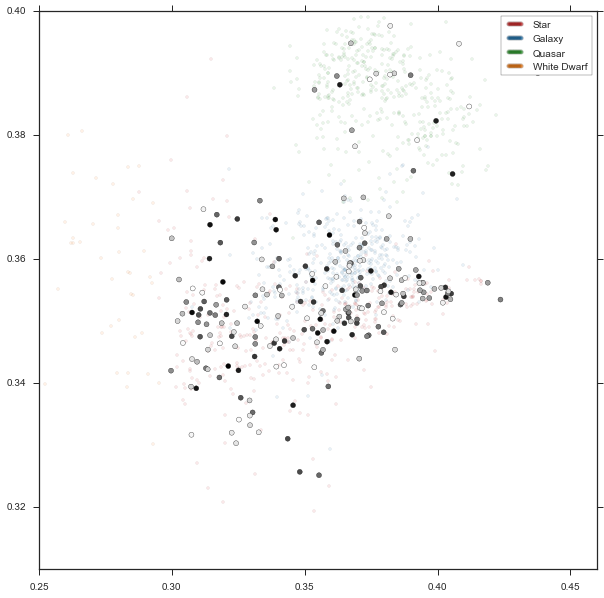

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = plot_scatter_with_classes(X_train[:, [5,6]], y_train, classes, alpha=0.1, size=10, scatterpoints=100)
ax.set_xlim(0.24, 0.45)
ax.set_ylim(0.32, 0.4)

d1 = X[:, [5,6]][order[50:]][:,0]
d2 = X[:, [5,6]][order[50:]][:,1]

ax.scatter(d1, d2, s=25, alpha=1, c=np.arange(250, 0, -1))
ax.set_xlim(0.25, 0.46)
ax.set_ylim(0.31, 0.4)

(0.31, 0.4)

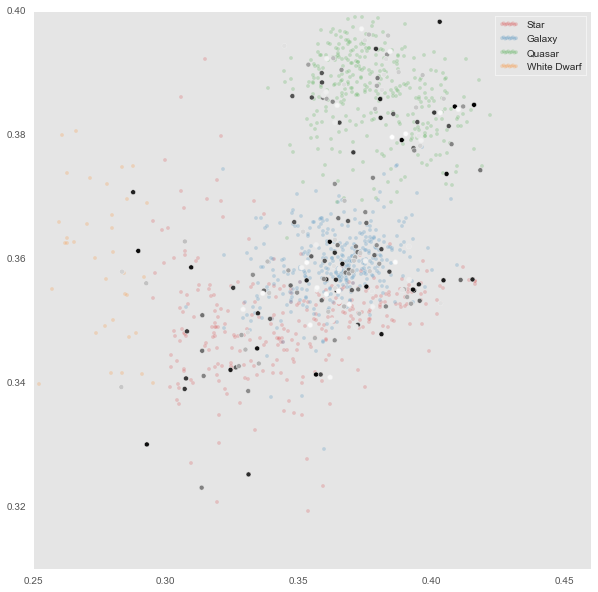

In [94]:
fig = plt.figure(figsize=(10, 10))
ax = plot_scatter_with_classes(X_train[:, [5,6]], y_train, classes, alpha=0.2)
ax.set_xlim(0.2, 0.5)
ax.set_ylim(0.2, 0.5)

d1 = X_train[:, [5,6]][order[50:]][:,0]
d2 = X_train[:, [5,6]][order[50:]][:,1]

ax.scatter(d1, d2, s=25, alpha=1, c=np.arange(250, 0, -1))
ax.set_xlim(0.25, 0.46)
ax.set_ylim(0.31, 0.4)

In [76]:
def plot_scatter_with_classes(data, targets, classes, size=15, alpha=0.2,
    scatterpoints=10, ax=None):
    
    if not ax:
        ax = plt.gca()

    class_data = {}
    cls_scatters = []
    for i, cls in enumerate(classes):
        class_data[cls] = data[targets == cls]
        cls_scatter = ax.scatter(class_data[cls][:,0], class_data[cls][:,1], s=size,
            alpha=alpha, c=tableau10[i], label=cls)
        cls_scatters.append(cls_scatter)

    ax.legend(cls_scatters, classes, scatterpoints=scatterpoints, loc='upper right',
        frameon=True, ncol=1)
    ax.grid(False)

    return ax

In [66]:
list(np.arange(10, 0, -1))

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

(0.2, 0.5)

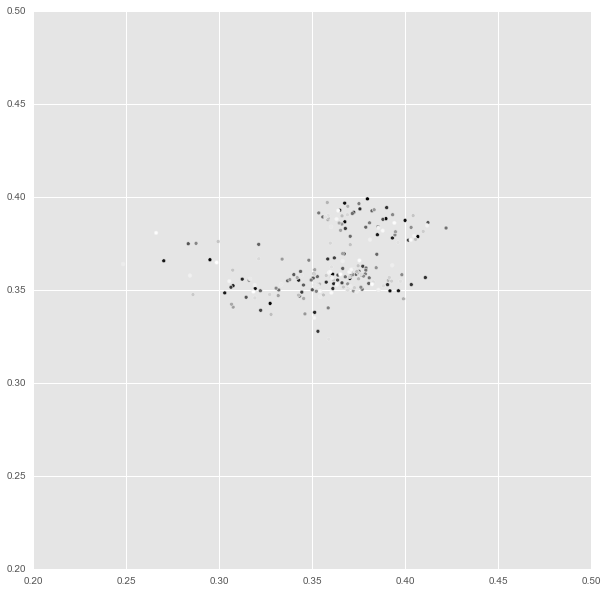

82
71
61
36


(-7, 5)

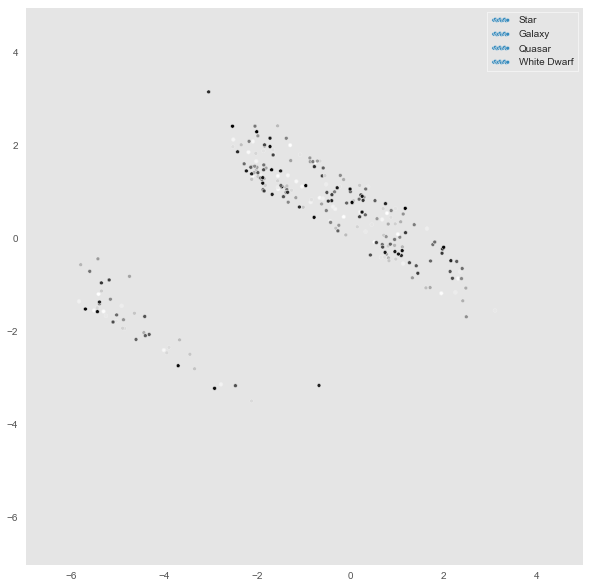

In [55]:
fig = plt.figure(figsize=(10, 10))
ax = plot_scatter_with_classes(X_train_p[order[50:]], y_train[order[50:]], classes, alpha=1)
ax.set_xlim(-7, 5)
ax.set_ylim(-7, 5)